# Boston Data
- A data set containing housing values in 506 suburbs of Boston.
- There are 13 variables:
    - crim: Crime rate per person in each town.
    - zn: Percentage of residential land for large lots (over 25,000 sq. ft).
    - indus: Percentage of land used for non-retail businesses in each town.
    - chas: Whether the area borders the Charles River (1 = yes, 0 = no).
    - nox: Levels of nitrogen oxides in the air (per 10 million parts).
    - rm: Average number of rooms in homes.
    - age: Percentage of homes built before 1940.
    - dis: Average distance to five employment centers in Boston.
    - rad: Ease of access to highways.
    - tax: Property tax rate per $10,000.
    - ptratio: Student-to-teacher ratio in schools by town.
    - lstat: Percentage of lower-income residents.
    - medv: Median home value in thousands of dollars.
- The target variable is `medv`.


# Load Packages and Data

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import sklearn.model_selection as skm
from sklearn.tree import (DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score, log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
from ISLP.bart import BART

In [2]:
Boston = load_data("Boston")
Boston.head(2)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6


In [3]:
Boston.describe().round(3)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
count,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000
mean,3.614,11.364,11.137,0.069,0.555,6.285,68.575,3.795,9.549,408.237,18.456,12.653,22.533
std,8.602,23.322,6.860,0.254,0.116,0.703,28.149,2.106,8.707,168.537,2.165,7.141,9.197
min,0.006,0.000,0.460,0.000,0.385,3.561,2.900,1.130,1.000,187.000,12.600,1.730,5.000
25%,0.082,0.000,5.190,0.000,0.449,5.885,45.025,2.100,4.000,279.000,17.400,6.950,17.025
50%,0.257,0.000,9.690,0.000,0.538,6.208,77.500,3.207,5.000,330.000,19.050,11.360,21.200
75%,3.677,12.500,18.100,0.000,0.624,6.624,94.075,5.188,24.000,666.000,20.200,16.955,25.000
max,88.976,100.000,27.740,1.000,0.871,8.780,100.000,12.126,24.000,711.000,22.000,37.970,50.000


# Fitting Regression Trees
- We create a design matrix that includes all the variables except `medv`.
- We need to convert the design matrix to `ndarray` for the `DecisionTreeRegressor()` function.
- We save column names for later use.

In [4]:
featureDF = MS(Boston.columns.drop('medv'), intercept=False).fit_transform(Boston)
feature_names = list(featureDF.columns)
featureARR = np.asarray(featureDF)

- We split the data into training and test sets (30%).

In [5]:
X_train, X_test, y_train, y_test = skm.train_test_split(
    featureARR, Boston.medv, test_size=0.3, random_state=0)

- After creating our training and test data sets, we fit the regression tree.

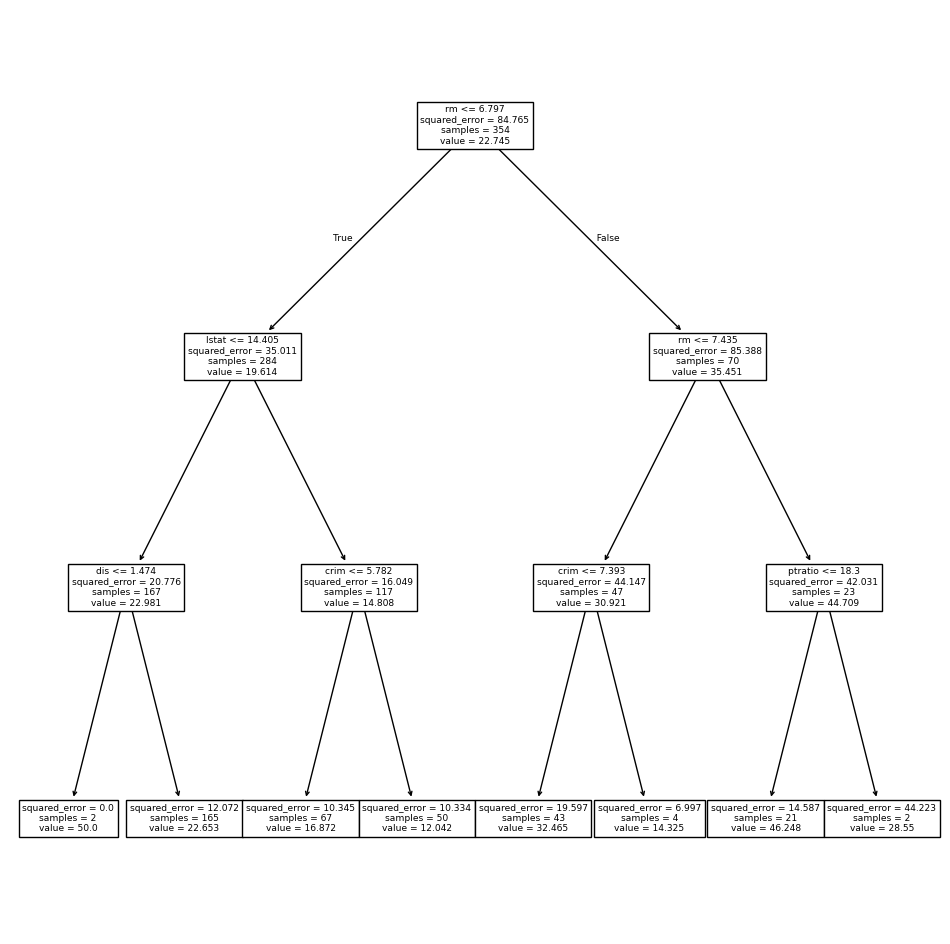

In [6]:
# Set and fit regression tree
TRE_Reg = DTR(max_depth=3)
TRE_Reg.fit(X_train, y_train)
# Plot tree
ax = plt.subplots(figsize=(12,12))[1]
plot_tree(TRE_Reg, feature_names=feature_names, ax=ax);

In [7]:
print(export_text(TRE_Reg, feature_names=feature_names))

|--- rm <= 6.80
|   |--- lstat <= 14.40
|   |   |--- dis <= 1.47
|   |   |   |--- value: [50.00]
|   |   |--- dis >  1.47
|   |   |   |--- value: [22.65]
|   |--- lstat >  14.40
|   |   |--- crim <= 5.78
|   |   |   |--- value: [16.87]
|   |   |--- crim >  5.78
|   |   |   |--- value: [12.04]
|--- rm >  6.80
|   |--- rm <= 7.43
|   |   |--- crim <= 7.39
|   |   |   |--- value: [32.47]
|   |   |--- crim >  7.39
|   |   |   |--- value: [14.32]
|   |--- rm >  7.43
|   |   |--- ptratio <= 18.30
|   |   |   |--- value: [46.25]
|   |   |--- ptratio >  18.30
|   |   |   |--- value: [28.55]



- `rm` is average number of room. `lstat` is percentage of individuals with lower income.
- The tree analysis reveals that lower values of `lstat` (less neighborhood poverty) are linked to more expensive houses.
- For example, it predicts a median house price of $12,042 for small homes (`rm < 6.8`) located in areas where the socioeconomic status is low (`lstat > 14.4`) and the crime rate is moderate (`crim > 5.8`).

- We now use cross-validation to determine if pruning the tree improves performance.

Training MSE: 12.619014523843608
Testing MSE: 28.06985754975404


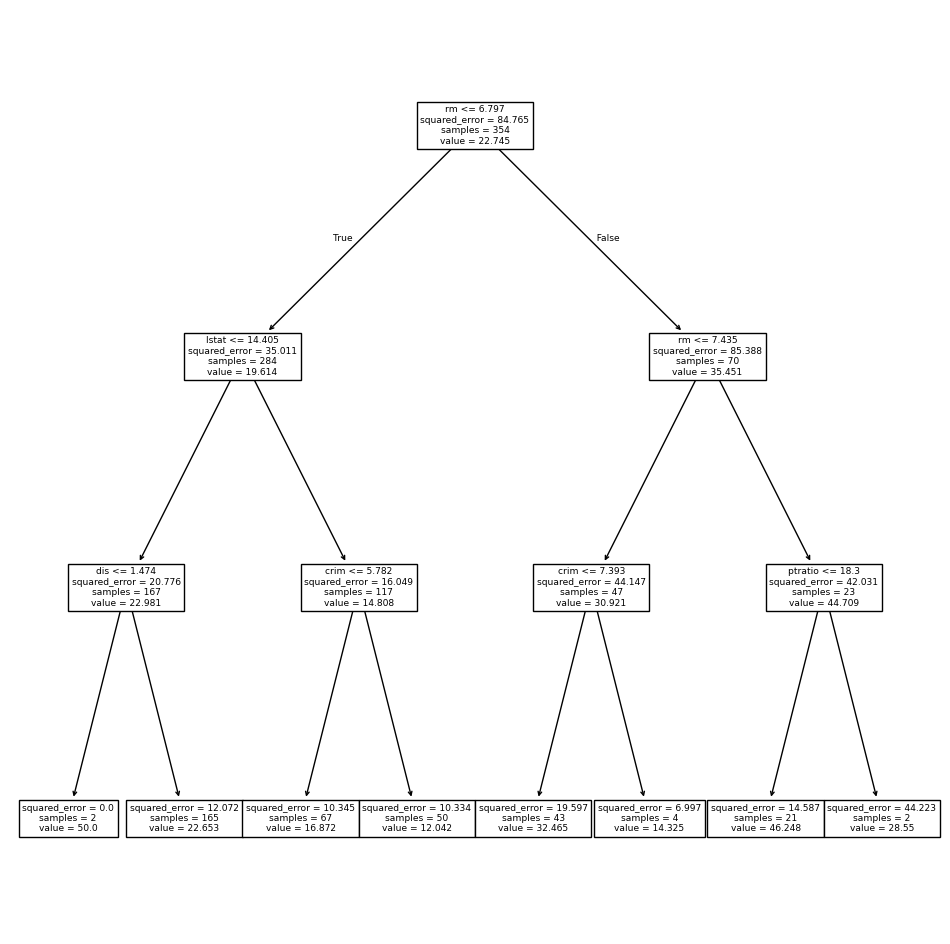

In [8]:
# Find the optimal depth
ccp_path = TRE_Reg.cost_complexity_pruning_path(X_train, y_train)
# Set 5-fold cross-validation
kfold = skm.KFold(5, shuffle=True, random_state=10)
# Set grid search
grid = skm.GridSearchCV(TRE_Reg, {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True, cv=kfold,
                        scoring='neg_mean_squared_error').fit(X_train, y_train)
best_ = grid.best_estimator_
# Show training MSE
print('Training MSE:', np.mean((best_.predict(X_train) - y_train) ** 2))
# Show testing MSE
print('Testing MSE:', np.mean((best_.predict(X_test) - y_test) ** 2))
# Plot tree
ax = plt.subplots(figsize=(12,12))[1]
plot_tree(best_, feature_names=feature_names, ax=ax);

- The test set MSE for the regression tree is $28.07 = 5.30^2$.  It means that, on average, the difference between the predicted home value given by the model and the true home value is about $5300.
- We rerun with the grown tree without max depth.

Training MSE: 2.9986528771295915
Testing MSE: 24.790824052062433


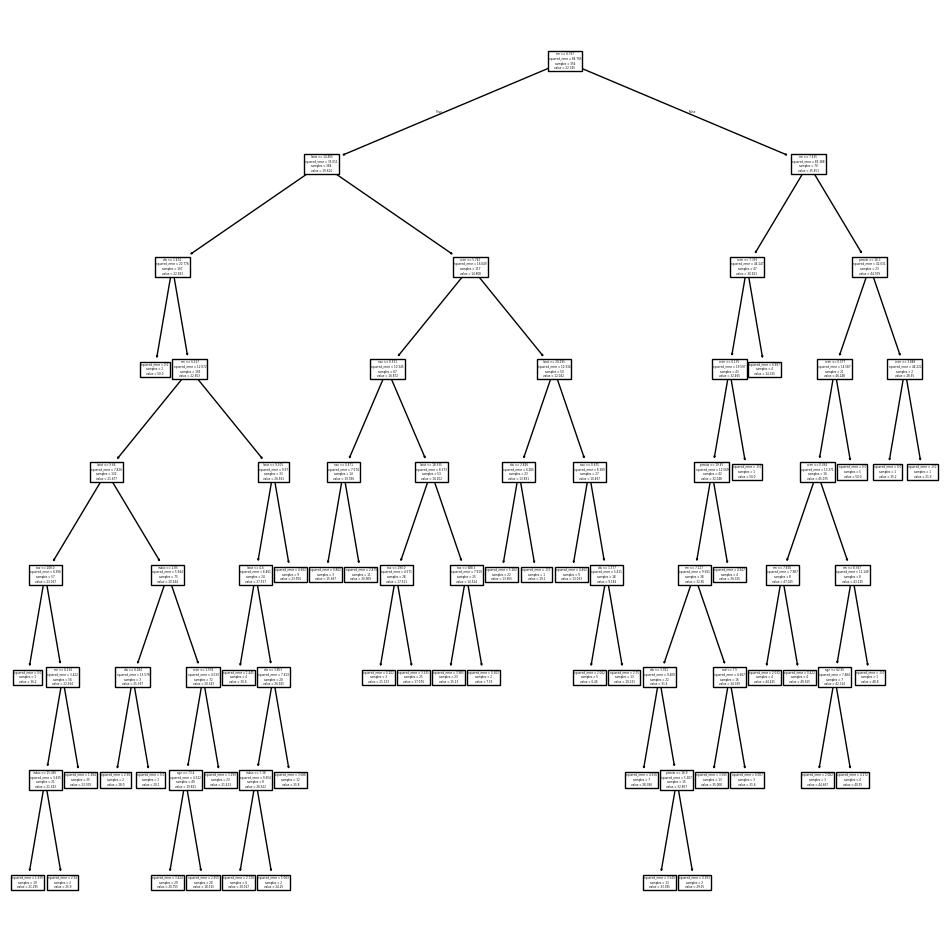

In [9]:
# Rerun with no restriction on depth
TRE_RegNo = DTR(random_state=2)
TRE_RegNo.fit(X_train, y_train)
# Find the optimal depth
ccp_path = TRE_RegNo.cost_complexity_pruning_path(X_train, y_train)
# Set 5-fold cross-validation
kfold = skm.KFold(5, shuffle=True, random_state=10)
# Set grid search
grid = skm.GridSearchCV(TRE_RegNo, {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True, cv=kfold,
                        scoring='neg_mean_squared_error').fit(X_train, y_train)
best_ = grid.best_estimator_
# Show training MSE
print('Training MSE:', np.mean((best_.predict(X_train) - y_train) ** 2))
# Show testing MSE
print('Testing MSE:', np.mean((best_.predict(X_test) - y_test) ** 2))
# Plot tree
ax = plt.subplots(figsize=(12,12))[1]
plot_tree(best_, feature_names=feature_names, ax=ax);

# Bagging and Random Forests
- We use `RandomForestRegressor()` from package `sklearn.ensemble` to fit bagging and random forest models.

## Bagging
- Bagging is a special case of random forests with `m = p` (all variables are considered at each split).

In [10]:
BAGG_boston = RF(max_features=X_train.shape[1], random_state=0).fit(X_train, y_train)

- We set `max_features` to 12, which means that all 12 predictors are considered for each tree split. This indicates that we're using bagging.
- We evaluate the test set MSE for the bagging model and plot scatter plots of the predicted vs. true values.

Training MSE: 1.3714658389830505
Testing MSE: 14.634700151315787


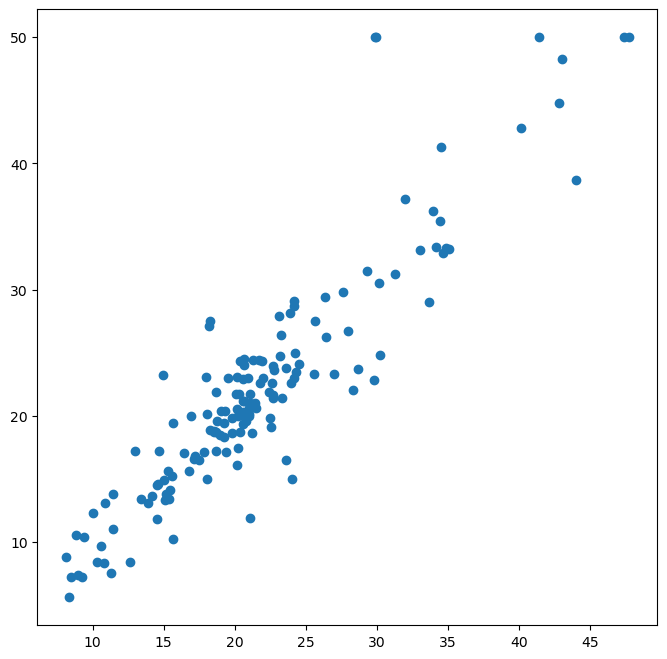

In [11]:
# Show training MSE
print('Training MSE:', np.mean((BAGG_boston.predict(X_train) - y_train) ** 2))
# Show testing MSE
print('Testing MSE:', np.mean((BAGG_boston.predict(X_test) - y_test) ** 2))
# Plot
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(BAGG_boston.predict(X_test), y_test);

- The test set MSE for the bagged regression tree is 14.63 ≈ half of that achieved with an optimally pruned single tree.
- We adjust the number of trees grown from the default of 100 by using the `n_estimators` argumentent.

In [12]:
BAGG_boston = RF(max_features=X_train.shape[1],
                n_estimators=500,
                random_state=0).fit(X_train, y_train)
# Show training MSE
print('Training MSE:', np.mean((BAGG_boston.predict(X_train) - y_train) ** 2))
# Show testing MSE
print('Testing MSE:', np.mean((BAGG_boston.predict(X_test) - y_test) ** 2))

Training MSE: 1.377549768248583
Testing MSE: 14.605662565263161


- The result is not changed.
- There is no risk of overfitting when increasing the number of trees in bagging and random forests.
- However, having too few trees can lead to underfitting.

## Random Forest
- Growing a random forest is similar to bagging, but with a smaller `max_features` value.
    - By default, `RandomForestRegressor()` uses all $p$ variables (defaulting to bagging), while `RandomForestClassifier()` uses $\sqrt{p}$  variables. In this case, we set `max_features=6`.

In [13]:
RF_boston = RF(max_features=6,
               random_state=0).fit(X_train, y_train)
# Show training MSE
print('Training MSE:', np.mean((RF_boston.predict(X_train) - y_train) ** 2))
# Show testing MSE
print('Testing MSE:', np.mean((RF_boston.predict(X_test) - y_test) ** 2))

Training MSE: 1.132428629943503
Testing MSE: 20.04276446710527


- The test set MSE for the random forest is 20.04, indicating that it performed somewhat worse than bagging in this case.
- We use the `feature_importances_` attribute to determine the importance of each variable.

In [14]:
feature_imp = pd.DataFrame(
    {'importance':RF_boston.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
lstat,0.356203
rm,0.332163
ptratio,0.067270
crim,0.055404
indus,0.053851
dis,0.041582
nox,0.035225
tax,0.025355
age,0.021506
rad,0.004784


- The results show that, among all the trees in the random forest, the community's wealth level (`lstat`) and the house size (`rm`) are the two most important variables by far.
- This measure is based on the average decrease in node impurity across all trees in the forest when a split is made on a particular variable.

# Boosting

- We use `GradientBoostingRegressor()` from `sklearn.ensemble` to fit boosted regression trees
- We use `GradientBoostingClassifier()` for classification.
- The argument:
    - `n_estimators=5000` specifies that we want to create 5,000 trees
    - `max_depth=3` limits the depth of each tree
    - `learning_rate` parameter corresponds to the $\lambda$ discussed earlier in the description of boosting.

In [15]:
boost_boston = GBR(n_estimators=5000,
                   learning_rate=0.001,
                   max_depth=3,
                   random_state=0)
boost_boston.fit(X_train, y_train)
# Show training MSE
print('Training MSE:', np.mean((boost_boston.predict(X_train) - y_train) ** 2))
# Show testing MSE
print('Testing MSE:', np.mean((boost_boston.predict(X_test) - y_test) ** 2))

Training MSE: 2.58076297351306
Testing MSE: 14.481405918831591


- The test MSE obtained is 14.48, similar to the MSE for bagging.
- We can track the decrease in training error using the `train_score_` attribute.

In [16]:
# Track the decrease in training error
boost_boston.train_score_

array([84.62029462, 84.47636406, 84.33272122, ...,  2.5816546 ,
        2.58114409,  2.58076297])

- We use the `staged_predict()` method to calculate the test MSE at each stage of boosting.

In [17]:
test_error = np.zeros_like(boost_boston.train_score_)
for idx, y_ in enumerate(boost_boston.staged_predict(X_test)):
   test_error[idx] = np.mean((y_test - y_)**2)
test_error

array([83.63320204, 83.49995557, 83.36699764, ..., 14.4826231 ,
       14.48212645, 14.48140592])

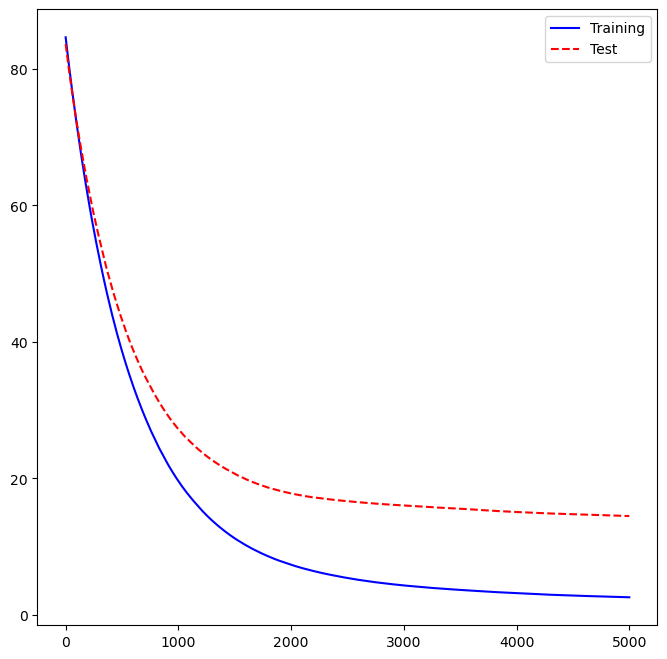

In [18]:
# Set the index for number of iterations
plot_idx = np.arange(boost_boston.train_score_.shape[0])
# Set the plot up
ax = plt.subplots(figsize=(8,8))[1]
# Plot the training error in blue
ax.plot(plot_idx,
        boost_boston.train_score_,
        'b', label='Training')
# Plot the testing error in red
ax.plot(plot_idx,
        test_error,
        'r--', label='Test')
ax.legend();


- We can perform boosting with a different shrinkage parameter $\lambda$. 
- The default value is 0.001.
- We change it to $\lambda=0.2$.

In [19]:
boost_boston = GBR(n_estimators=5000,
                   learning_rate=0.2,
                   max_depth=3,
                   random_state=0)
boost_boston.fit(X_train,
                 y_train)
y_hat_boost = boost_boston.predict(X_test);
np.mean((y_test - y_hat_boost)**2)

14.501514553719565

- In this case, using $\lambda=0.2$ leads to a almost the same test MSE as when using $\lambda=0.001$.

# Bayesian Additive Regression Trees

- We use `BART()` from the `ISLP.bart` package to fit a Bayesian additive regression tree model.
- The `BART()` function is tailored for quantitative outcome variables, although other implementations exist for logistic and probit models for categorical outcomes.
- The arguments:
    - `burnin`: the number of iterations to discard as burn-in
    - `ndraw`: the number of iterations to keep after burn-in

In [26]:
# Set and fit a BART model
bart_boston = BART(random_state=0, burnin=5, ndraw=15).fit(X_train, y_train)

In [27]:
# Show training MSE
print('Training MSE:', np.mean((bart_boston.predict(X_train.astype(np.float32)) - y_train) ** 2))
# Show testing MSE
print('Testing MSE:', np.mean((bart_boston.predict(X_test.astype(np.float32)) - y_test) ** 2))

Training MSE: 6.613154129794612
Testing MSE: 22.145009458109225


- The result shows that the test MSE for BART is comparable to that of the random forest.
- We check the frequency of each variable's appearance across all trees. This is similar to the variable importance measure in random forests.
- We can check the frequency of each variable's appearance across the collection of trees, providing a summary similar to the variable importance plot for boosting and random forests.

In [22]:
variable_inclusion = pd.Series(bart_boston.variable_inclusion_.mean(0), index=Design_matrix.columns)
variable_inclusion.sort_values(ascending=False)

lstat      31.000000
rm         29.800000
zn         27.866667
crim       26.933333
nox        26.600000
indus      26.466667
dis        26.466667
ptratio    24.266667
tax        24.133333
rad        23.666667
age        22.733333
chas       22.466667
dtype: float64